Processing: HL2_20250317_165753.wav


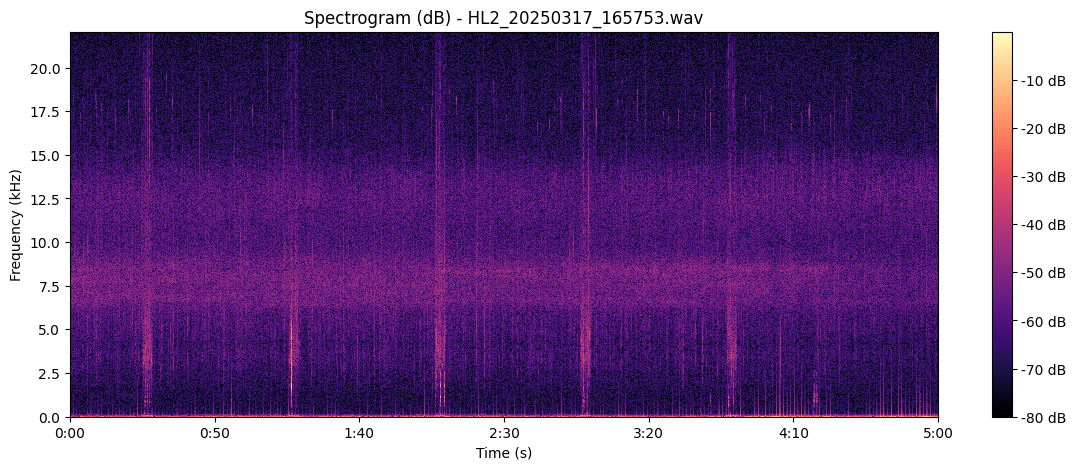

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

def plot_spectrogram(audio_path):
    """
    Plot the spectrogram of an audio file without log scale and with frequency in kHz.
    """
    print(f"Processing: {audio_path}")
    
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Compute the Short-Time Fourier Transform (STFT) and convert to dB
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Plot spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')  # Use linear scale
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram (dB) - {audio_path}')
    
    # Customize y-axis to display in kHz
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1000:.1f}'))
    plt.ylabel('Frequency (kHz)')
    plt.xlabel('Time (s)')
    plt.show()

# Example usage
if __name__ == "__main__":
    audio_file = "HL2_20250317_165753.wav"  # Replace with the actual file path
    plot_spectrogram(audio_file)

Processing: HL2_20250317_165753.wav


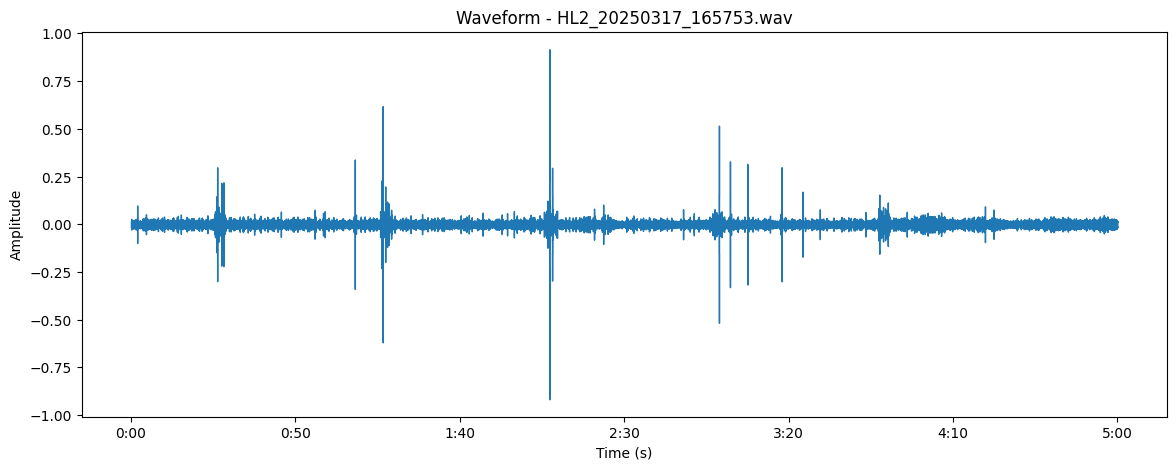

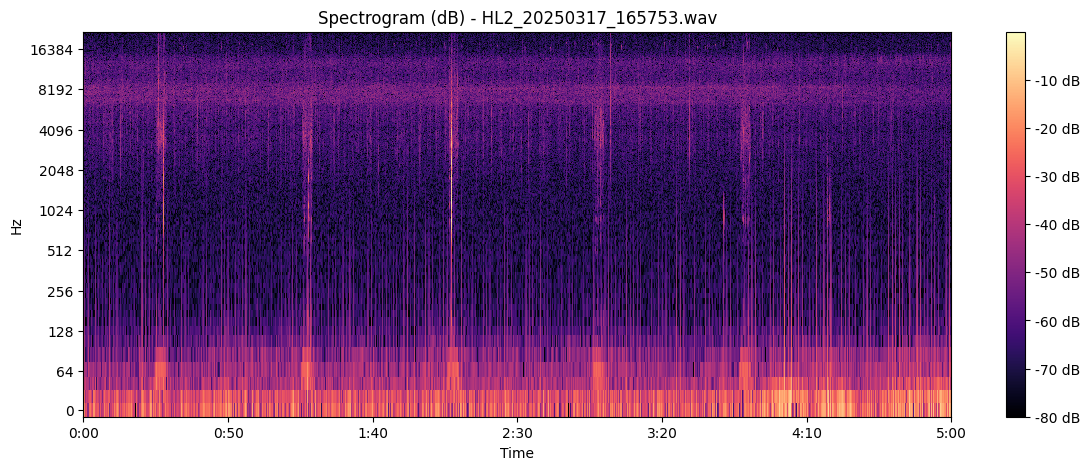

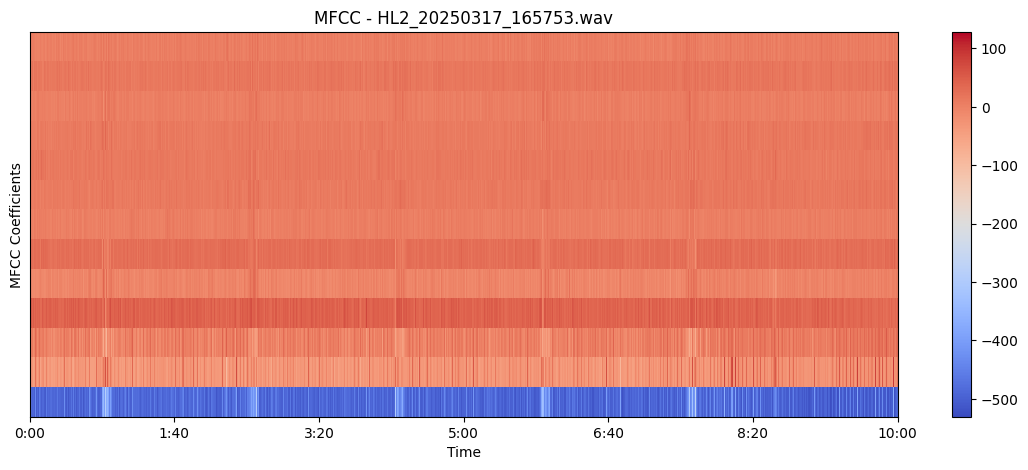

MFCCs saved to HL2_20250317_165753.wav_mfcc_features.csv


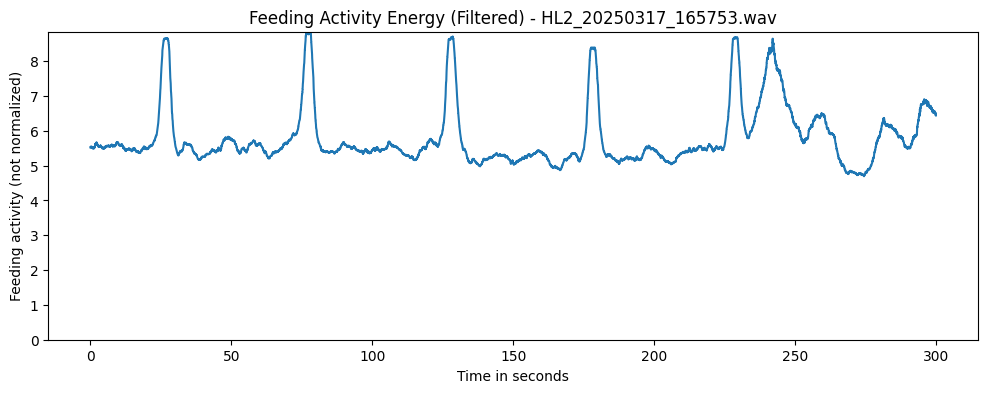

Feeding activity data saved to HL2_20250317_165753.wav_feeding_activity_energy.csv


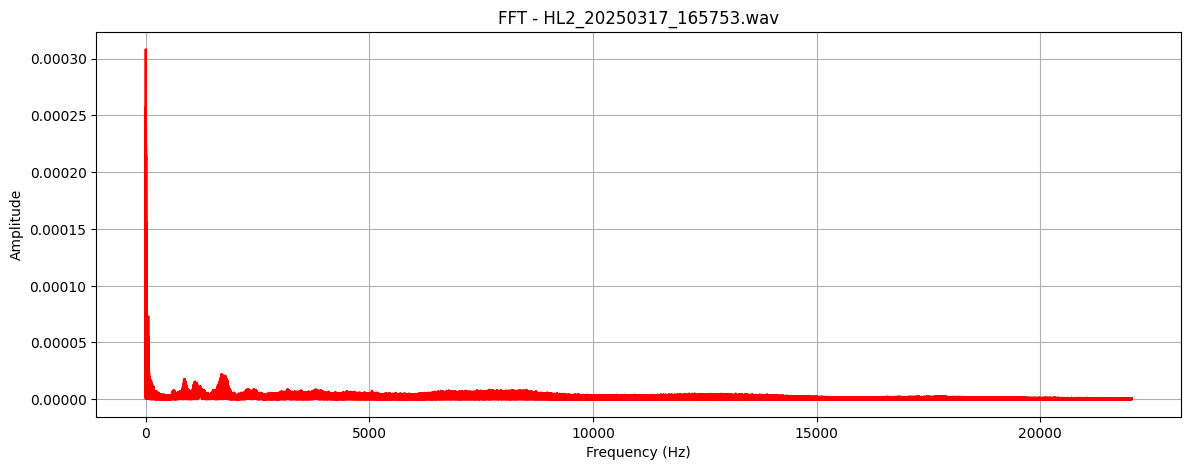

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
from scipy.fftpack import fft
from scipy.ndimage import median_filter

def process_audio_file(audio_path):
    """
    Process a single audio file to plot waveform, spectrogram, MFCC, energy, and FFT.
    """
    print(f"Processing: {audio_path}")
    
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # 1. Plot waveform
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {audio_path}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    # 2. Plot spectrogram (Short-Time Fourier Transform)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram (dB) - {audio_path}')
    plt.show()

    # 3. Extract and plot MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCC - {audio_path}')
    plt.ylabel('MFCC Coefficients')
    plt.show()

    # Optional: Save the MFCCs for further analysis
    mfcc_filename = f"{audio_path}_mfcc_features.csv"
    np.savetxt(mfcc_filename, mfccs, delimiter=',')
    print(f"MFCCs saved to {mfcc_filename}")

    # 4. Analyze energy across all frequencies (feeding activity)

    # Parameters for energy calculation
    win_length = int(sr / 1000 * 10)  # 10 ms window length
    hop_length = int(win_length // 2 + 1)
    n_fft = int(2 ** np.ceil(np.log2(win_length)))

    # Compute the Short-Time Fourier Transform (STFT)
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

    # Frequency bins (in Hz)
    f = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    t = librosa.frames_to_time(np.arange(0, S.shape[1]), sr=sr, hop_length=hop_length)

    # Compute energy across all frequencies (sum across frequency bins)
    frame_wise_energy = np.sum(np.abs(S), axis=0)

    # Apply median filtering for smoother energy calculation
    medfilt_size = 997
    frame_wise_energy = median_filter(frame_wise_energy, size=medfilt_size)

    # Plot the filtered energy
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(t, frame_wise_energy)
    ax.set_ylim(0, np.max(frame_wise_energy))  # Dynamically adjust y-axis
    ax.set_xlabel('Time in seconds')
    ax.set_ylabel('Feeding activity (not normalized)')
    plt.title(f'Feeding Activity Energy (Filtered) - {audio_path}')
    plt.show()

    # Save the energy data for further analysis
    energy_filename = f"{audio_path}_feeding_activity_energy.csv"
    df = pd.DataFrame({'time': t, 'energy': frame_wise_energy})
    df.to_csv(energy_filename, index=False)
    print(f"Feeding activity data saved to {energy_filename}")

    # 5. Compute and plot FFT
    N = len(y)
    yf = fft(y)
    xf = np.linspace(0.0, sr / 2.0, N // 2)

    plt.figure(figsize=(14, 5))
    plt.plot(xf, 2.0 / N * np.abs(yf[:N // 2]), color="red")
    plt.title(f'FFT - {audio_path}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

def process_multiple_audio_files(audio_files):
    """
    Process multiple audio files.
    """
    for audio_path in audio_files:
        process_audio_file(audio_path)


# Example usage
if __name__ == "__main__":
    # Replace with paths to your 3 audio files
    audio_files = [
        "HL2_20250317_165753.wav",  # Replace with the actual file paths
    ]
    process_multiple_audio_files(audio_files)

In [2]:
import gc
gc.collect()


16

Audio duration: 300.00 seconds
Sampling rate: 44100 Hz
Number of clicks detected: 5
Click timestamps (seconds): ['28.13', '76.59', '127.23', '182.17', '228.73']
Intervals between clicks (seconds): ['48.46', '50.64', '54.94', '46.56']
Average interval: 50.15 seconds
Overall CPS (Clicks Per Second): 0.0167
Local CPS (Clicks Per Second, from first to last click): 0.0199


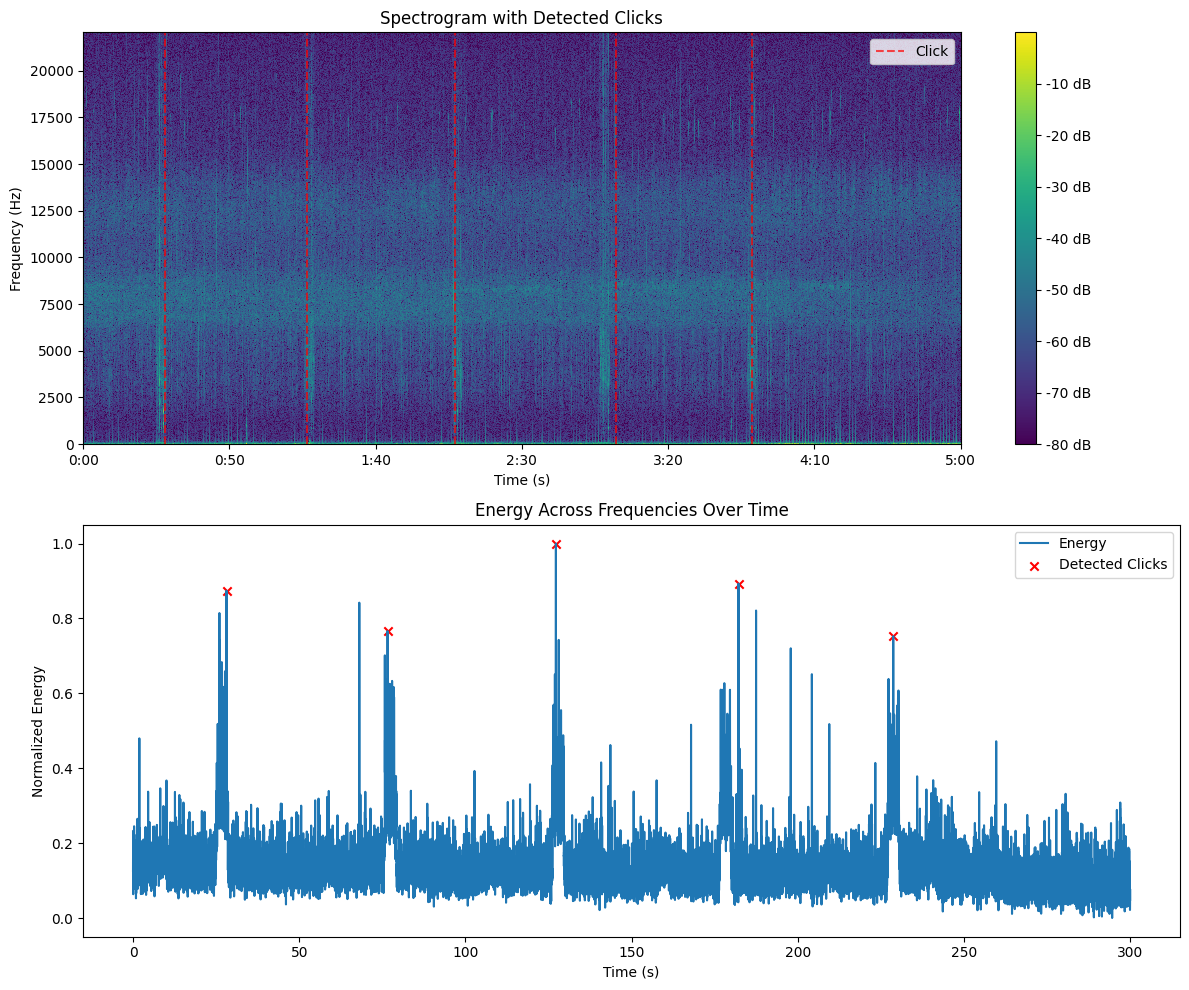

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Step 1: Load the audio file
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

# Step 2: Compute the spectrogram
def compute_spectrogram(audio, sr, hop_length=512, n_fft=2048):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    return spectrogram, stft

# Step 3: Detect clicks with refined logic
def detect_clicks(spectrogram, sr, hop_length, threshold_db=-20, min_distance=50, expected_interval=50, tolerance=5):
    # Sum the energy across all frequencies for each time frame
    energy = np.sum(spectrogram, axis=0)
    # Normalize energy
    energy = (energy - np.min(energy)) / (np.max(energy) - np.min(energy))
    
    # Find peaks in the energy signal
    peaks, properties = find_peaks(energy, height=threshold_db, distance=min_distance, prominence=0.1)
    
    # Convert peak indices to time
    times = librosa.frames_to_time(peaks, sr=sr, hop_length=hop_length)
    
    # Filter peaks based on interval consistency
    if len(times) > 1:
        intervals = np.diff(times)
        # Keep only peaks where intervals are close to the expected 50 seconds (within tolerance)
        valid_peaks = [peaks[0]]  # Always keep the first peak
        valid_times = [times[0]]
        
        for i in range(1, len(times)):
            if abs(intervals[i-1] - expected_interval) <= tolerance:
                valid_peaks.append(peaks[i])
                valid_times.append(times[i])
    
        peaks = np.array(valid_peaks)
        times = np.array(valid_times)
    
    # Additional filtering: Ensure peaks have sufficient energy relative to the mean
    mean_energy = np.mean(energy)
    peak_energies = energy[peaks]
    valid_indices = peak_energies > (mean_energy + 0.2)  # Must be significantly above mean energy
    peaks = peaks[valid_indices]
    times = times[valid_indices]
    
    return peaks, times, energy

# Step 4: Plot the spectrogram and energy signal
def plot_spectrogram_and_energy(spectrogram, sr, hop_length, click_times, peaks, energy, audio_duration):
    # Plot spectrogram
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram with Detected Clicks')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    
    # Mark detected clicks
    for t in click_times:
        plt.axvline(x=t, color='r', linestyle='--', alpha=0.7, label='Click' if t == click_times[0] else "")
    plt.legend()
    
    # Plot energy signal
    plt.subplot(2, 1, 2)
    times = librosa.frames_to_time(np.arange(len(energy)), sr=sr, hop_length=hop_length)
    plt.plot(times, energy, label='Energy')
    plt.scatter(click_times, energy[peaks], color='r', label='Detected Clicks', marker='x')
    plt.title('Energy Across Frequencies Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Energy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Step 5: Main function with CPS calculation
def analyze_audio(file_path, threshold_db=-20, min_distance_seconds=40, expected_interval=50, tolerance=5):
    # Load audio
    audio, sr = load_audio(file_path)
    audio_duration = len(audio) / sr
    print(f"Audio duration: {audio_duration:.2f} seconds")
    print(f"Sampling rate: {sr} Hz")

    # Compute spectrogram
    hop_length = 512
    n_fft = 2048
    spectrogram, stft = compute_spectrogram(audio, sr, hop_length=hop_length, n_fft=n_fft)

    # Detect clicks
    min_distance = int(min_distance_seconds * sr / hop_length)
    peaks, click_times, energy = detect_clicks(spectrogram, sr, hop_length, threshold_db=threshold_db, 
                                              min_distance=min_distance, expected_interval=expected_interval, 
                                              tolerance=tolerance)

    # Print results
    print(f"Number of clicks detected: {len(click_times)}")
    print("Click timestamps (seconds):", [f"{t:.2f}" for t in click_times])

    # Calculate intervals between clicks
    if len(click_times) > 1:
        intervals = np.diff(click_times)
        print("Intervals between clicks (seconds):", [f"{i:.2f}" for i in intervals])
        print(f"Average interval: {np.mean(intervals):.2f} seconds")

    # Calculate CPS (Clicks Per Second)
    if len(click_times) > 0:
        # Overall CPS over the entire audio duration
        overall_cps = len(click_times) / audio_duration
        print(f"Overall CPS (Clicks Per Second): {overall_cps:.4f}")

        # Local CPS over the active period (from first to last click)
        if len(click_times) > 1:
            active_duration = click_times[-1] - click_times[0]
            local_cps = (len(click_times) - 1) / active_duration  # Number of intervals / active duration
            print(f"Local CPS (Clicks Per Second, from first to last click): {local_cps:.4f}")

    # Plot the spectrogram and energy signal
    plot_spectrogram_and_energy(spectrogram, sr, hop_length, click_times, peaks, energy, audio_duration)

# Example usage
if __name__ == "__main__":
    file_path = "HL2_20250317_165753.wav"  # Update with your actual file path
    try:
        analyze_audio(file_path, threshold_db=-20, min_distance_seconds=40, expected_interval=50, tolerance=5)
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found. Please provide a valid audio file path.")